In [1]:
!pip install detectors

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
import numpy as np

In [3]:
start_time = time.time()

def check_time():
    elapsed = (time.time() - start_time) / 3600
    remaining = 3.9 - elapsed  # Leave 6 min buffer
    print(f"Time used: {elapsed:.2f}h | Remaining: {remaining:.2f}h")
    return remaining > 0.1  # Stop if <6 mins left

In [4]:
import detectors
import timm

teacher = timm.create_model("resnet50_cifar100", pretrained=True)

/opt/conda/lib/python3.12/site-packages/outdated/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
print(device)

cuda


In [7]:
teacher = teacher.to(device)
teacher.eval()

print("ResNet50 Teacher loaded successfully!")
print(f"Parameters: {sum(p.numel() for p in teacher.parameters()):,}")

ResNet50 Teacher loaded successfully!
Parameters: 23,705,252


In [8]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), 
                         (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), 
                         (0.2675, 0.2565, 0.2761))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

check_time()

Time used: 0.00h | Remaining: 3.90h


True

In [9]:
teacher.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = teacher(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

teacher_acc = 100. * correct / total
print(f"Teacher accuracy: {teacher_acc:.2f}%")

Teacher accuracy: 80.93%


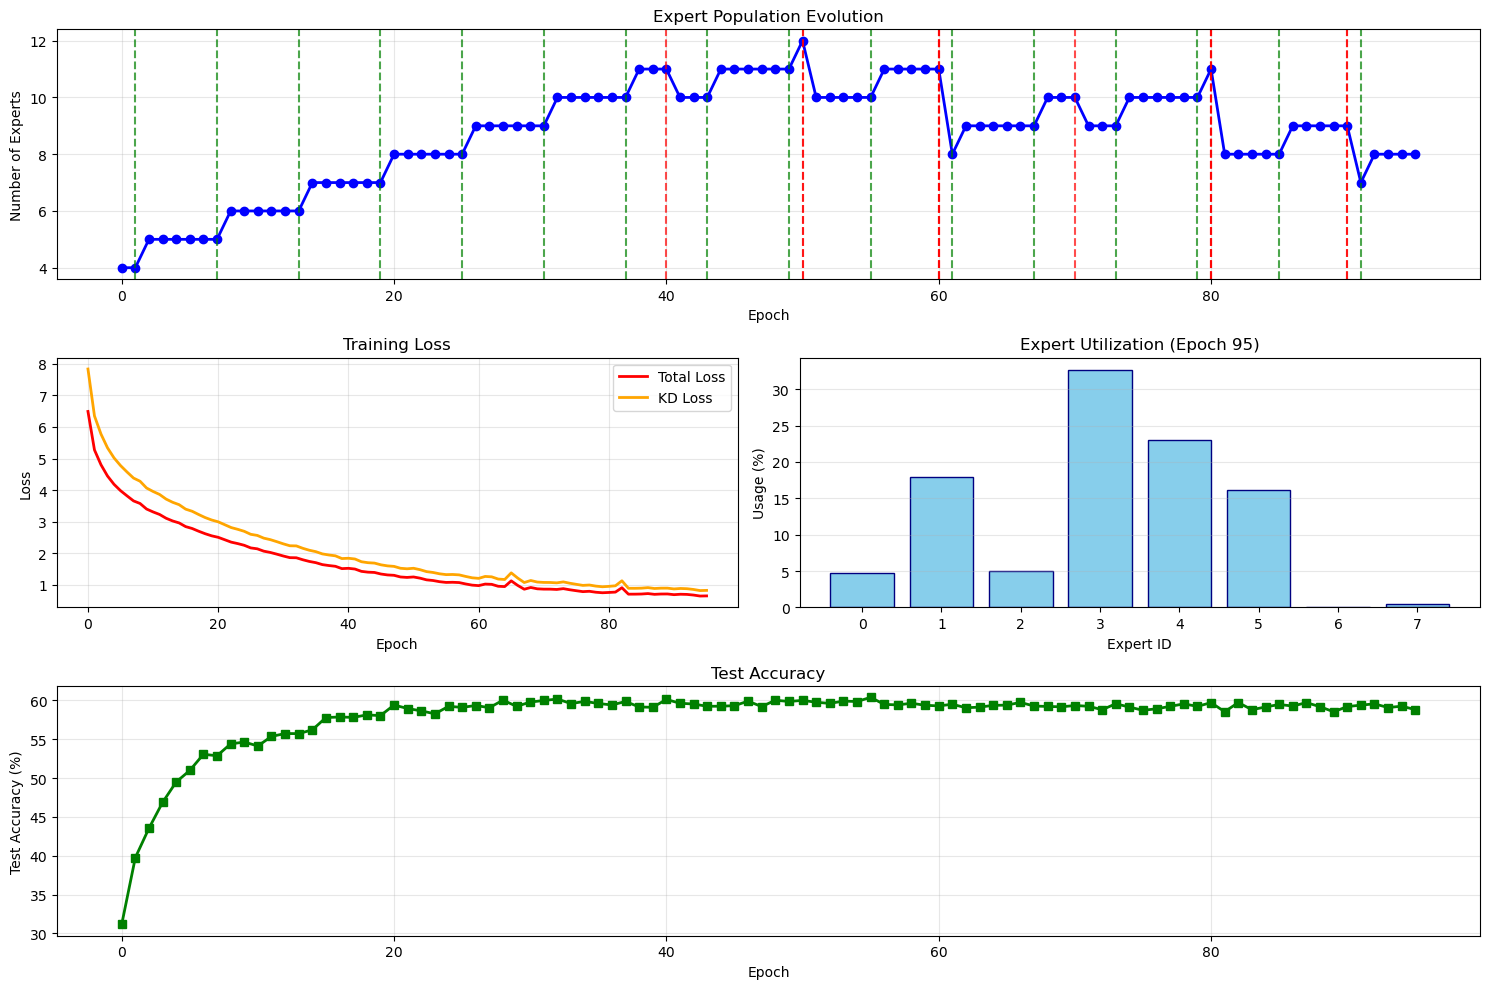

Epoch 96 | Batch 0 | Loss: 0.708 | Experts: 8
Epoch 96 | Batch 100 | Loss: 0.554 | Experts: 8


KeyboardInterrupt: 

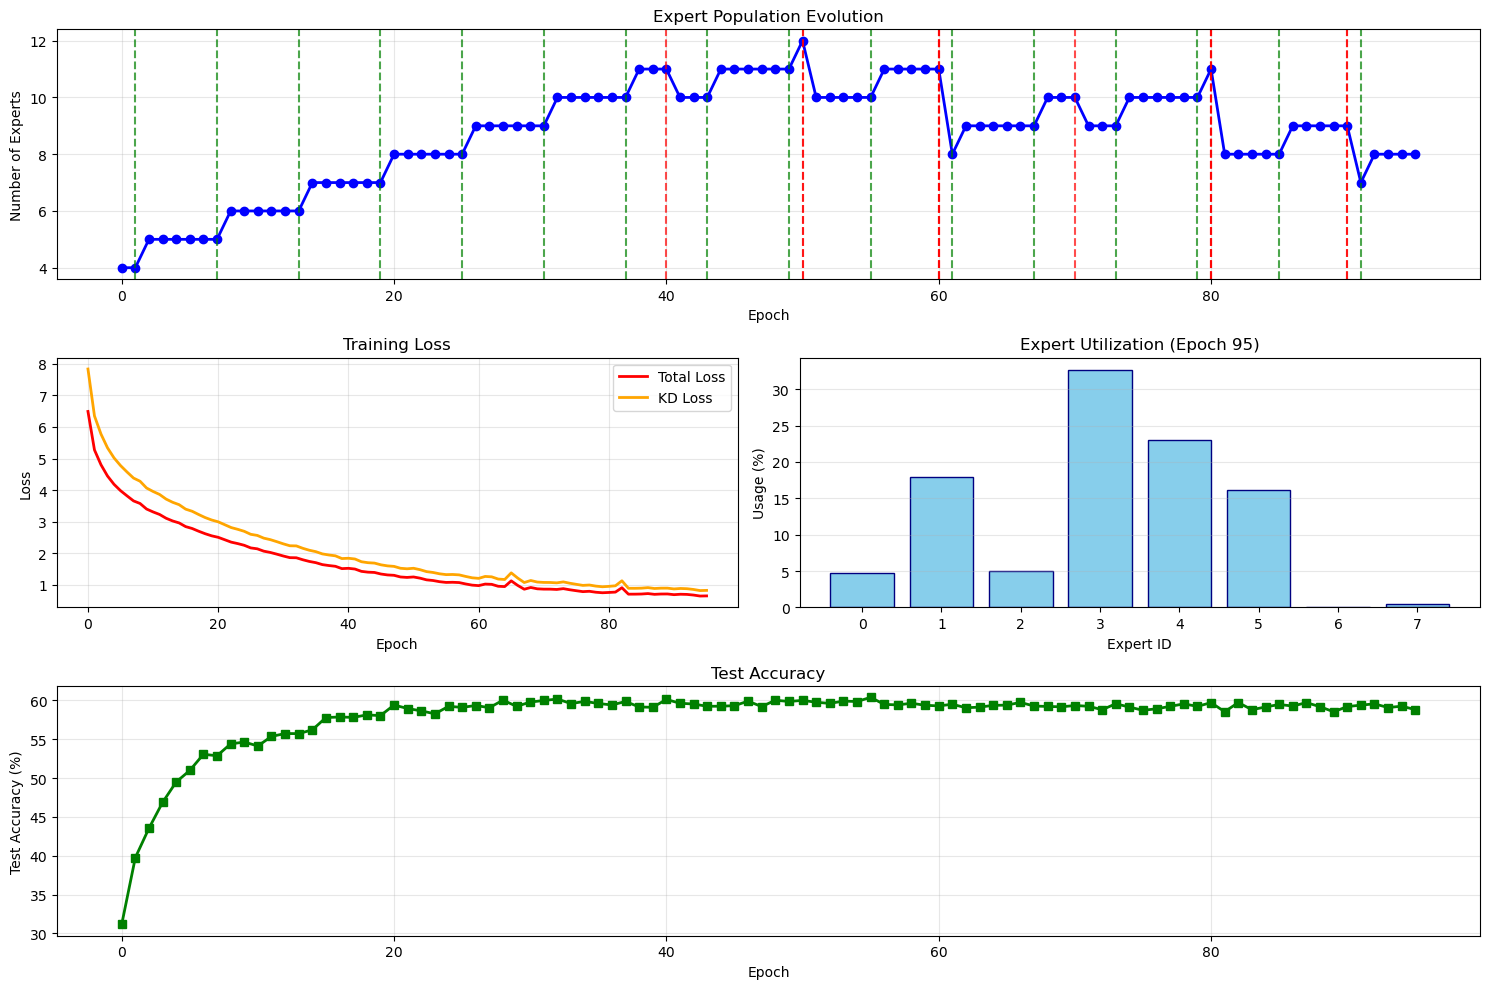

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Expert class (same as before)
class Expert(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=512):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)

# Gating Network (same as before)
class GatingNetwork(nn.Module):
    def __init__(self, input_dim, num_experts, hidden_dim=256):
        super().__init__()
        self.gate = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_experts),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.gate(x)

# MoE Layer (same as before)
class MixtureOfExpertsLayer(nn.Module):
    def __init__(self, input_dim, num_experts, expert_output_dim):
        super().__init__()
        self.num_experts = num_experts
        self.experts = nn.ModuleList([
            Expert(input_dim, expert_output_dim) 
            for _ in range(num_experts)
        ])
        self.gate = GatingNetwork(input_dim, num_experts)
    
    def forward(self, x):
        batch_size = x.size(0)
        gate_weights = self.gate(x)
        expert_outputs = torch.stack([
            expert(x) for expert in self.experts
        ], dim=1)
        gate_weights = gate_weights.unsqueeze(-1)
        output = (expert_outputs * gate_weights).sum(dim=1)
        return output, gate_weights.squeeze(-1)
    
    def add_expert(self):
        """Add a new expert to the MoE"""
        input_dim = 512
        expert_output_dim = 256
        new_expert = Expert(input_dim, expert_output_dim).to(next(self.parameters()).device)
        self.experts.append(new_expert)
        self.num_experts += 1
        
        # Update gating network
        old_gate = self.gate.gate
        new_gate = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, self.num_experts),
            nn.Softmax(dim=-1)
        ).to(next(self.parameters()).device)
        
        with torch.no_grad():
            new_gate[0].weight[:] = old_gate[0].weight
            new_gate[0].bias[:] = old_gate[0].bias
            new_gate[2].weight[:-1] = old_gate[2].weight
            new_gate[2].bias[:-1] = old_gate[2].bias
        
        self.gate.gate = new_gate
    
    def remove_expert(self, expert_idx):
        """Remove an expert from the MoE"""
        if len(self.experts) <= 2:
            return
        
        # Store old num_experts before deletion
        old_num_experts = self.num_experts
        
        del self.experts[expert_idx]
        self.num_experts -= 1
        
        # Update gating network
        input_dim = 512
        old_gate = self.gate.gate
        new_gate = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, self.num_experts),
            nn.Softmax(dim=-1)
        ).to(next(self.parameters()).device)
        
        with torch.no_grad():
            # Copy first layer weights
            new_gate[0].weight[:] = old_gate[0].weight
            new_gate[0].bias[:] = old_gate[0].bias
            
            # Copy output weights excluding the removed expert
            # Create mask for all experts EXCEPT the removed one
            mask = torch.cat([
                torch.arange(expert_idx),
                torch.arange(expert_idx + 1, old_num_experts)
            ]).long()
            
            new_gate[2].weight[:] = old_gate[2].weight[mask]
            new_gate[2].bias[:] = old_gate[2].bias[mask]
        
        self.gate.gate = new_gate

# Student Model
class AdaptiveMoEStudent(nn.Module):
    def __init__(self, num_classes=100, num_initial_experts=4):
        super().__init__()
        resnet18 = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet18.children())[:-1])
        self.moe_layer = MixtureOfExpertsLayer(
            input_dim=512,
            num_experts=num_initial_experts,
            expert_output_dim=256
        )
        self.classifier = nn.Linear(256, num_classes)
    
    def forward(self, x):
        features = self.backbone(x)
        features = features.view(features.size(0), -1)
        moe_output, gate_weights = self.moe_layer(features)
        logits = self.classifier(moe_output)
        return logits, gate_weights

# Expert Tracker
class ExpertTracker:
    def __init__(self, num_experts, window_size=5):
        self.window_size = window_size
        self.num_experts = num_experts
        self.expert_kd_losses = [[] for _ in range(num_experts)]
        self.expert_usage_counts = [0] * num_experts
        self.expert_outputs_history = [[] for _ in range(num_experts)]
        self.epoch_history = {
            'kd_loss': [[] for _ in range(num_experts)],
            'usage': [[] for _ in range(num_experts)]
        }
    
    def add_expert(self):
        self.num_experts += 1
        self.expert_kd_losses.append([])
        self.expert_usage_counts.append(0)
        self.expert_outputs_history.append([])
        self.epoch_history['kd_loss'].append([])
        self.epoch_history['usage'].append([])
    
    def update_batch(self, expert_idx, kd_loss, gate_weight, expert_output):
        self.expert_kd_losses[expert_idx].append(kd_loss)
        self.expert_usage_counts[expert_idx] += gate_weight
        if len(self.expert_outputs_history[expert_idx]) < 100:
            self.expert_outputs_history[expert_idx].append(expert_output.detach().cpu())
    
    def end_epoch(self):
        for i in range(self.num_experts):
            if len(self.expert_kd_losses[i]) > 0:
                avg_kd = np.mean(self.expert_kd_losses[i])
            else:
                avg_kd = float('inf')
            
            self.epoch_history['kd_loss'][i].append(avg_kd)
            self.epoch_history['usage'][i].append(self.expert_usage_counts[i])
            
            if len(self.epoch_history['kd_loss'][i]) > self.window_size:
                self.epoch_history['kd_loss'][i] = self.epoch_history['kd_loss'][i][-self.window_size:]
                self.epoch_history['usage'][i] = self.epoch_history['usage'][i][-self.window_size:]
        
        self.expert_kd_losses = [[] for _ in range(self.num_experts)]
        self.expert_usage_counts = [0] * self.num_experts
    
    def get_avg_kd_loss(self, expert_idx):
        history = self.epoch_history['kd_loss'][expert_idx]
        if len(history) == 0:
            return float('inf')
        return np.mean(history)
    
    def get_avg_usage(self, expert_idx):
        history = self.epoch_history['usage'][expert_idx]
        if len(history) == 0:
            return 0
        return np.mean(history)
    
    def compute_expert_similarity(self, expert_i, expert_j):
        outputs_i = self.expert_outputs_history[expert_i]
        outputs_j = self.expert_outputs_history[expert_j]
        
        if len(outputs_i) == 0 or len(outputs_j) == 0:
            return 0.0
        
        min_len = min(len(outputs_i), len(outputs_j), 50)
        outputs_i = torch.stack(outputs_i[-min_len:])
        outputs_j = torch.stack(outputs_j[-min_len:])
        
        outputs_i = outputs_i.flatten()
        outputs_j = outputs_j.flatten()
        
        similarity = F.cosine_similarity(outputs_i.unsqueeze(0), outputs_j.unsqueeze(0))
        return similarity.item()
    
    def remove_expert(self, expert_idx):
        self.expert_kd_losses.pop(expert_idx)
        self.expert_usage_counts.pop(expert_idx)
        self.expert_outputs_history.pop(expert_idx)
        self.epoch_history['kd_loss'].pop(expert_idx)
        self.epoch_history['usage'].pop(expert_idx)
        self.num_experts -= 1

def should_prune_expert(tracker, expert_idx, min_epochs=10):
    if len(tracker.epoch_history['kd_loss'][expert_idx]) < min_epochs:
        return False, "Insufficient history"
    
    avg_kd = tracker.get_avg_kd_loss(expert_idx)
    avg_usage = tracker.get_avg_usage(expert_idx)
    
    total_usage = sum(tracker.get_avg_usage(i) for i in range(tracker.num_experts))
    usage_fraction = avg_usage / (total_usage + 1e-8)
    
    all_kd = [tracker.get_avg_kd_loss(i) for i in range(tracker.num_experts)]
    avg_global_kd = np.mean([x for x in all_kd if x != float('inf')])
    
    if usage_fraction < 0.05 and avg_kd < 0.5 * avg_global_kd:
        return True, f"Low usage ({usage_fraction:.3f}) + low KD loss ({avg_kd:.3f})"
    
    if usage_fraction < 0.05 and avg_kd > 2.0 * avg_global_kd:
        return True, f"Low usage ({usage_fraction:.3f}) + high KD loss ({avg_kd:.3f})"
    
    for other_idx in range(tracker.num_experts):
        if other_idx == expert_idx:
            continue
        
        similarity = tracker.compute_expert_similarity(expert_idx, other_idx)
        if similarity > 0.95:
            other_kd = tracker.get_avg_kd_loss(other_idx)
            if avg_kd > other_kd:
                return True, f"High similarity ({similarity:.3f}) with expert {other_idx}"
    
    return False, "Performing well"

def get_expert_usage(gate_weights_batch):
    avg_weights = gate_weights_batch.mean(dim=0).cpu().numpy()
    usage_percent = (avg_weights / avg_weights.sum()) * 100
    return usage_percent.tolist()

def evaluate_student(student, testloader, device):
    student.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = student(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return 100. * correct / total

def train_adaptive_moe_with_viz(student, teacher, trainloader, testloader, 
                                device, training_history, ax1, ax2, ax3, ax4, 
                                max_hours=3.0):
    teacher.eval()
    optimizer = torch.optim.Adam(student.parameters(), lr=0.001)
    
    birth_threshold = 0.5
    birth_cooldown = 5
    last_birth_epoch = -birth_cooldown
    
    death_check_interval = 10
    death_cooldown = 5
    last_death_epoch = -death_cooldown
    
    num_experts = len(student.moe_layer.experts)
    tracker = ExpertTracker(num_experts=num_experts, window_size=10)
    
    epoch = 0
    start_time = time.time()
    
    def check_time():
        return (time.time() - start_time) < (max_hours * 3600)
    
    def update_viz():
        if len(training_history['epochs']) == 0:
            return
        
        try:
            for ax in [ax1, ax2, ax3, ax4]:
                ax.clear()
            
            epochs = training_history['epochs']
            
            # Plot 1: Expert growth
            ax1.plot(epochs, training_history['num_experts'], 'b-', linewidth=2, marker='o')
            for birth_epoch in training_history['expert_birth_epochs']:
                ax1.axvline(birth_epoch, color='green', linestyle='--', alpha=0.7)
            for death_epoch in training_history['expert_death_epochs']:
                ax1.axvline(death_epoch, color='red', linestyle='--', alpha=0.7)
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Number of Experts')
            ax1.set_title('Expert Population Evolution')
            ax1.grid(True, alpha=0.3)
            
            # Plot 2: Loss
            ax2.plot(epochs, training_history['losses'], 'r-', label='Total Loss', linewidth=2)
            ax2.plot(epochs, training_history['kd_losses'], 'orange', label='KD Loss', linewidth=2)
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            ax2.set_title('Training Loss')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # Plot 3: Expert utilization
            if len(training_history['expert_usage']) > 0:
                latest_usage = training_history['expert_usage'][-1]
                ax3.bar(range(len(latest_usage)), latest_usage, color='skyblue', edgecolor='navy')
                ax3.set_xlabel('Expert ID')
                ax3.set_ylabel('Usage (%)')
                ax3.set_title(f'Expert Utilization (Epoch {epochs[-1]})')
                ax3.grid(True, alpha=0.3, axis='y')
            
            # Plot 4: Accuracy
            ax4.plot(epochs, training_history['accuracies'], 'g-', linewidth=2, marker='s')
            ax4.set_xlabel('Epoch')
            ax4.set_ylabel('Test Accuracy (%)')
            ax4.set_title('Test Accuracy')
            ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            
            # Force update in Jupyter
            from IPython.display import clear_output, display
            clear_output(wait=True)
            display(fig)
            
        except Exception as e:
            print(f"Visualization update error: {e}")
    
    while check_time():
        student.train()
        epoch_losses = []
        epoch_kd_losses = []
        all_gate_weights = []
        
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Get features for expert tracking
            with torch.no_grad():
                features = student.backbone(inputs)
                features = features.view(features.size(0), -1)
                teacher_logits = teacher(inputs)
            
            student_logits, gate_weights = student(inputs)
            all_gate_weights.append(gate_weights.detach())
            
            # Track individual expert outputs - FIXED HERE
            with torch.no_grad():
                for expert_idx, expert in enumerate(student.moe_layer.experts):
                    # Expert forward returns only the output, not a tuple
                    expert_output = expert(features)
                    
                    # Calculate KD loss contribution for this expert
                    expert_gate = gate_weights[:, expert_idx]
                    
                    # Simple KD loss estimation
                    ce_loss = nn.CrossEntropyLoss()(student_logits, targets)
                    kd_loss = nn.KLDivLoss(reduction='batchmean')(
                        nn.functional.log_softmax(student_logits / 3, dim=1),
                        nn.functional.softmax(teacher_logits / 3, dim=1)
                    ) * (3 ** 2)
                    
                    expert_kd = kd_loss.item() * expert_gate.mean().item()
                    
                    tracker.update_batch(
                        expert_idx, 
                        expert_kd, 
                        expert_gate.sum().item(),
                        expert_output
                    )
            
            # Compute loss
            ce_loss = nn.CrossEntropyLoss()(student_logits, targets)
            kd_loss = nn.KLDivLoss(reduction='batchmean')(
                nn.functional.log_softmax(student_logits / 3, dim=1),
                nn.functional.softmax(teacher_logits / 3, dim=1)
            ) * (3 ** 2)
            
            loss = 0.7 * kd_loss + 0.3 * ce_loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
            epoch_kd_losses.append(kd_loss.item())
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch} | Batch {batch_idx} | Loss: {loss.item():.3f} | '
                      f'Experts: {len(student.moe_layer.experts)}')
        
        tracker.end_epoch()
        
        all_gate_weights = torch.cat(all_gate_weights, dim=0)
        expert_usage = get_expert_usage(all_gate_weights)
        accuracy = evaluate_student(student, testloader, device)
        
        training_history['epochs'].append(epoch)
        training_history['num_experts'].append(len(student.moe_layer.experts))
        training_history['losses'].append(np.mean(epoch_losses))
        training_history['kd_losses'].append(np.mean(epoch_kd_losses))
        training_history['accuracies'].append(accuracy)
        training_history['expert_usage'].append(expert_usage)
        
        print(f'\n=== Epoch {epoch} Summary ===')
        print(f'Accuracy: {accuracy:.2f}%')
        print(f'Num Experts: {len(student.moe_layer.experts)}')
        
        # Death mechanism
        if (epoch > 20 and 
            epoch % death_check_interval == 0 and 
            epoch - last_death_epoch > death_cooldown):
            
            print("\n🔍 Checking for expert pruning...")
            experts_to_remove = []
            
            for expert_idx in range(len(student.moe_layer.experts)):
                should_prune, reason = should_prune_expert(tracker, expert_idx, min_epochs=10)
                avg_kd = tracker.get_avg_kd_loss(expert_idx)
                avg_usage = tracker.get_avg_usage(expert_idx)
                total_usage = sum(tracker.get_avg_usage(i) for i in range(tracker.num_experts))
                usage_frac = avg_usage / (total_usage + 1e-8)
                
                print(f"  Expert {expert_idx}: KD={avg_kd:.3f}, Usage={usage_frac:.3f} - {reason}")
                
                if should_prune:
                    experts_to_remove.append(expert_idx)
            
            for expert_idx in sorted(experts_to_remove, reverse=True):
                if len(student.moe_layer.experts) > 2:
                    student.moe_layer.remove_expert(expert_idx)
                    print(f"💀 REMOVED Expert {expert_idx} at Epoch {epoch}!")
                    training_history['expert_death_epochs'].append(epoch)
                    last_death_epoch = epoch
                    tracker.remove_expert(expert_idx)
                    optimizer = torch.optim.Adam(student.parameters(), lr=0.001)
        
        # Birth mechanism
        expert_added = False
        if epoch - last_birth_epoch > birth_cooldown and len(student.moe_layer.experts) < 12:
            if np.mean(epoch_kd_losses) > birth_threshold:
                student.moe_layer.add_expert()
                tracker.add_expert()
                last_birth_epoch = epoch
                training_history['expert_birth_epochs'].append(epoch)
                optimizer = torch.optim.Adam(student.parameters(), lr=0.001)
                expert_added = True
                print(f'\n✨ NEW EXPERT ADDED at Epoch {epoch}! '
                      f'Total: {len(student.moe_layer.experts)}\n')
        
        update_viz()
        
        if expert_added or (len(training_history['expert_death_epochs']) > 0 and 
                           training_history['expert_death_epochs'][-1] == epoch):
            plt.savefig(f'viz_expert_event_epoch{epoch}.png', dpi=300, bbox_inches='tight')
        
        epoch += 1
        
        if epoch % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': student.state_dict(),
                'num_experts': len(student.moe_layer.experts),
                'training_history': training_history
            }, f'checkpoint_ep{epoch}.pth')
            plt.savefig(f'viz_epoch{epoch}.png', dpi=300, bbox_inches='tight')
            check_time()
    
    print(f"\n⏰ Time limit reached. Trained for {epoch} epochs.")
    plt.savefig('training_visualization_final.png', dpi=300, bbox_inches='tight')
    
    return student


# ============================================
# MAIN TRAINING SCRIPT
# ============================================

if __name__ == "__main__":
    # Setup device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Load teacher model
    # Prepare datasets
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), 
                             (0.2675, 0.2565, 0.2761))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), 
                             (0.2675, 0.2565, 0.2761))
    ])
    
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, 
                                             download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR100(root='./data', train=False, 
                                            download=True, transform=transform_test)
    
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    
    print("Datasets loaded successfully!")
    
    # Create student model
    student = AdaptiveMoEStudent(num_classes=100, num_initial_experts=4)
    student = student.to(device)
    print(f"Student created with {sum(p.numel() for p in student.parameters())/1e6:.2f}M parameters")
    
    # Initialize training history
    training_history = {
        'epochs': [],
        'num_experts': [],
        'expert_birth_epochs': [],
        'expert_death_epochs': [],
        'losses': [],
        'kd_losses': [],
        'accuracies': [],
        'expert_usage': []
    }
    
    # Setup visualization
    plt.ion()
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(3, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, :])
    
    print("\n" + "="*50)
    print("Starting Adaptive MoE Training with Visualization")
    print("="*50 + "\n")
    
    # Train the model
    student = train_adaptive_moe_with_viz(
        student=student,
        teacher=teacher,
        trainloader=trainloader,
        testloader=testloader,
        device=device,
        training_history=training_history,
        ax1=ax1, ax2=ax2, ax3=ax3, ax4=ax4,
        max_hours=1.0  # Adjust time limit as needed
    )
    
    # Final evaluation
    final_accuracy = evaluate_student(student, testloader, device)
    print(f"\n" + "="*50)
    print(f"TRAINING COMPLETE!")
    print(f"Final Accuracy: {final_accuracy:.2f}%")
    print(f"Final Number of Experts: {len(student.moe_layer.experts)}")
    print(f"Expert Births: {len(training_history['expert_birth_epochs'])}")
    print(f"Expert Deaths: {len(training_history['expert_death_epochs'])}")
    print("="*50 + "\n")
    
    # Save final model
    torch.save({
        'model_state_dict': student.state_dict(),
        'training_history': training_history,
        'final_accuracy': final_accuracy,
        'num_experts': len(student.moe_layer.experts)
    }, 'student_adaptive_final.pth')
    
    print("Model saved to 'student_adaptive_final.pth'")
    
    # Keep plot open
    plt.ioff()
    plt.show()

In [12]:
final_accuracy = evaluate_student(student, testloader, device)
print(f"\n" + "="*50)
print(f"TRAINING COMPLETE!")
print(f"Final Accuracy: {final_accuracy:.2f}%")
print(f"Final Number of Experts: {len(student.moe_layer.experts)}")
print(f"Expert Births: {len(training_history['expert_birth_epochs'])}")
print(f"Expert Deaths: {len(training_history['expert_death_epochs'])}")
print("="*50 + "\n")
    


TRAINING COMPLETE!
Final Accuracy: 58.69%
Final Number of Experts: 8
Expert Births: 16
Expert Deaths: 12

